## **Traffic Simulation**

The notebook is expected to take approximately 25 minutes to run

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation 
from IPython import display 
import matplotlib as mpl
import matplotlib.colors as mcolors

## **Create a single road with 2 simultaneous traffic lights**

In [3]:
#Here and below the traffic simulation code is adapted from the CS166 Session 9 workbook
class Road:
    '''
    This class contains methods and attributes associated with a road object. 
    It creates a road with cars, updates the speeds and positions of cars at each timestep for a given number of timesteps.
    It also visualizes the traffic flow.
    '''

    def __init__(self, road_length=100, car_density=0.2, prob_slow=0.5,
                 max_speed=5,traffic_light_position=[10,90],traffic_light_state='green',traffic_light_switch=10):
        '''
        Create a new road object. Cars are distributed randomly
        along the road and start with random velocities. The other default parameters' values are chosen randomly
        ------
        Inputs:
        road_length: int
            the number of cells in the road
        car_density: float
            the fraction of cells that have a car on them
        prob_slow: float
            the probability that a car will randomly slow down by 1 during an update step
        max_speed: int
            the maximum speed in car cells per update step
        traffic_light_position : lst
            a list of indexes indicating the positions of the traffic lights on the road
        traffic_light_state: str
            an indicator if the traffic light is green or red at the moment
        traffic_light_switch: int
            the number of timesteps gree or red period lasts
        '''
        self.road_length = road_length
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow

        # Create an empty road: -1 means empty in this simulation
        self.state = np.full(self.road_length, -1, dtype=int)
        # Choose random locations to place cars
        random_indexes = np.random.choice(
            range(self.road_length),
            size=int(round(car_density * self.road_length)),
            replace=False)
        # Give each car a random initial speed from 0 to max_speed
        self.state[random_indexes] = np.random.randint(
            0, self.max_speed + 1, size=len(random_indexes))

        # Keep track of the time steps and average traffic flow at each step
        self.time_step = 0
        self.average_traffic_flow = []

        #create a traffic lights at a certain positions with corresponding switch time
        self.traffic_light_position=traffic_light_position
        self.traffic_light_state=traffic_light_state
        self.traffic_light_switch=traffic_light_switch
        self.traffic_light_timer=0

    def update(self, optimized=True):
        '''
        Advance one time step in the simulation.
        '''

        car_pos=[]

        #Traffic Light Switch

        if self.traffic_light_timer==self.traffic_light_switch: #update traffic light every 3 steps (from red to green or the other way around)
            if self.traffic_light_state=='red':
                self.traffic_light_state='green'
            else:
                self.traffic_light_state='red'

            self.traffic_light_timer=0 #reset timer to 0


        #Traffic Light conditions

        if self.traffic_light_state=='red':
            for pos in self.traffic_light_position:
                #if there is no car at the traffic light already 
                if self.state[pos]==-1:
                    #move from the traffic light position back (left) 
                    for i in range(pos-1,pos-self.max_speed-1,-1):
                        if self.state[i]!=-1: #if we found a car

                            #if the car goes beyong traffic light - stop it at the traffic light in the next timestep
                            if self.state[i]>=pos-i: 
                                self.state[i]=pos-i 
                                car_pos.append(i) 
                                break #stop after finding the first car
                else:
                    self.state[pos]=0 #if there is a car at red traffic light, change its speed to 0 (stop)

        
        # Update car speeds
        for i in range(self.road_length):
            if self.state[i] != -1:

                # Distance is the number of empty cells between this car and the
                # next car plus 1
                distance = 1
                while self.state[(i + distance) % self.road_length] == -1:
                    distance += 1
                # Acceleration
                if i not in car_pos:
                    if self.state[i] < self.max_speed :
                        if i not in self.traffic_light_position or self.traffic_light_state=='green':
                            self.state[i] += 1

                # Deceleration
                if self.state[i] >= distance:
                    self.state[i] = distance - 1
                # Randomization

                if (
                    (self.state[i] > 0) and
                    (np.random.uniform() < self.prob_slow)
                ):
                    self.state[i] -= 1

        # Move cars forward using their new speeds
        new_state = np.full(self.road_length, -1, dtype=int)
        for i in range(self.road_length):
            cell = self.state[i]
            if cell != -1:
                new_state[(i + cell) % self.road_length] = cell
        self.state = new_state

        # Update average traffic flow history
        self.average_traffic_flow.append(
            sum(self.state[self.state > 0]) / self.road_length)
        self.time_step += 1
        self.traffic_light_timer+=1

    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        print(''.join('.' if x == -1 else str(x) for x in self.state))

    def show_traffic_lights(self): 
        '''
        This methods displays the traffic lights at their corresponding positions as circles
        '''
        for tl in self.traffic_light_position:
            plt.scatter(tl+1, 2, color = self.traffic_light_state, linewidth = 3)
              
                     
    def observe(self): 
        '''
        This method visualizes the road with proper coloring and traffic lights
        '''
        #set color
        road_colours = plt.cm.binary(np.linspace(0, 1, 5))
        car_colours = plt.cm.autumn(np.linspace(0, 1, self.max_speed+1))
        colours = np.vstack((road_colours, car_colours))
        cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colours)

        #show road and traffic lights
        plt.imshow([self.state], cmap = cmap, vmin = -self.max_speed, vmax = self.max_speed, extent=[0, self.road_length, 0, 1])
        plt.gca().axison = False
        plt.ylim(0, 3)
        self.show_traffic_lights() 
     
    def animate(self, i): 
        '''
        This method animates the road visualization as it updates each timestep
        '''
        self.observe() 
        self.update()
        return plt.show()

In [4]:
#Here and further the code to animate CA is adapted from CS166 Session 6

%matplotlib notebook

np.random.seed(23)

sim = Road(
    road_length=100, car_density=0.2, max_speed=5, prob_slow=0,traffic_light_state='red')

#produce and display the animation
fig = plt.figure(figsize=(20, 10))
anim = FuncAnimation(fig, sim.animate, frames=20, interval=200) #20 timesteps
video = anim.to_html5_video() 
html = display.HTML(video) 
display.display(html)
plt.close()


<IPython.core.display.Javascript object>

In [5]:
#display the first 20 consequetive updates in 'dots and numbers' format
for i in range(20):
    sim.display()
    sim.update(optimized=False)
final_state = sim.state.copy()

.....5....4......5.....5.....5.....5.......5.....5.....5..................000000.1..2...3.1........5
....5....40...........5.....5.....5.....5.......5.....5.....5.............00000.1..2...3.10.........
........400................5.....5.....5.....5.......5.....5.....5........0000.1..2...3.100.........
........000.....................5.....5.....5.....5.......5.....5.....5...000.1..2...3.1000.........
........000..........................5.....5.....5.....5.......5.....5...300.1..2...3.10000.........
........000...............................5.....5.....5.....5.......5...300.1..2...3.100000.........
........000....................................5.....5.....5.....5.....300.1..2...3.1000000.........
........000.........................................5.....5.....5.....500.1..2...3.10000000.........
........000..............................................5.....5.....500.1..2...3.100000000.........
........000...................................................5.....500.1..2...3.1000000000

## **Create 4 intersecting roads with 2 simultaneous traffic lights each**

In [6]:
class Road:
    '''
    This class contains methods and attributes associated with a road object. 
    It creates a road with cars, updates the speeds and positions of cars at each timestep for a given number of timesteps.
    It creates 4 intersections and allows cars to turn right.
    It also visualizes the traffic flow.
    '''

    def __init__(self, road_length=100, car_density=0.2, prob_slow=0.5,
                 max_speed=5,traffic_light_position=[10,39],traffic_light_state='green',traffic_light_switch=10, prob_turn_right=0.2):
        '''
        Create a new road object. Cars are distributed randomly
        along the road and start with random velocities. The other default parameters' values are chosen randomly
        ------
        Inputs:
        road_length: int
            the number of cells in the road
        car_density: float
            the fraction of cells that have a car on them
        prob_slow: float
            the probability that a car will randomly slow down by 1 during an update step
        max_speed: int
            the maximum speed in car cells per update step
        traffic_light_position : lst
            a list of indexes indicating the positions of the traffic lights on the road
        traffic_light_state: str
            an indicator if the traffic light is green or red at the moment
        traffic_light_switch: int
            the number of timesteps gree or red period lasts
        prop_turn_right: float
            the probability of a given car turning right as it passes through the intersection 
        '''
        self.road_length = road_length
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow
        self.prob_turn_right=prob_turn_right

        # Create an empty road: -1 means empty in this simulation
        self.state = np.full(self.road_length, -1, dtype=int)
        # Choose random locations to place cars
        random_indexes = np.random.choice(
            range(self.road_length),
            size=int(round(car_density * self.road_length)),
            replace=False)
        # Give each car a random initial speed from 0 to max_speed
        self.state[random_indexes] = np.random.randint(
            0, self.max_speed + 1, size=len(random_indexes))

        # Keep track of the time steps and average traffic flow at each step
        self.time_step = 0
        self.average_traffic_flow = []

        #create traffic lights at certain positions with corresponding switch time
        self.traffic_light_position=traffic_light_position
        self.traffic_light_state=traffic_light_state
        self.traffic_light_switch=traffic_light_switch
        self.traffic_light_timer=0

    def add_road(self,right_road):
        '''
        This method adds a right road - an intersecting road that a car can turn into from the current road.
        ------
        Inputs:
        right_road: Road()
            a Road() class object with the same methods and attributes as a current road
        '''
        self.right_road=right_road

    def update(self):
        '''
        Advance one time step in the simulation.
        '''

        car_pos=[]


        #Traffic Light Switch

        if self.traffic_light_timer==self.traffic_light_switch: #update traffic light every 3 steps (from red to green or the other way around)
            if self.traffic_light_state=='red':
                self.traffic_light_state='green'
            else:
                self.traffic_light_state='red'

            self.traffic_light_timer=0 #reset timer to 0



        #Traffic Light conditions

        if self.traffic_light_state=='red':
            for pos in self.traffic_light_position:
                #if there is no car at the traffic light already 
                if self.state[pos]==-1:
                    #move from the traffic light position back (left) 
                    for i in range(pos-1,pos-self.max_speed-1,-1):
                        if self.state[i]!=-1: #if we found a car

                            #if the car goes beyong traffic light - stop it at the traffic light in the next timestep
                            if self.state[i]>=pos-i: 
                                self.state[i]=pos-i 
                                car_pos.append(i) 
                                break #stop after finding the first car
                else:
                    self.state[pos]=0 #if there is a car at red traffic light, change its speed to 0 (stop)



        #Intersection Conditions

        def turn_right(i, end_pos, start_pos,speed_not_max=1):
            '''
            This helper function goes over the cells in the right road to find an empty space for a car to turn into from the current road.
            If an empty space is found, turn their by updating speeds accordingly
            ------
            Inputs:
            i: int
                index showing the position of a car found on the current road near the intersection
            end_pos: int
                the farthest position on the right road where the car can end up
            start_pos: int
                the closest position on the right road where the car can end up
            speed_not_max: 1 or 0
                a variable to indicate if we are dealing with a car which speed in maximum or not as the acceleration rule depends on it
            ------
            Outputs: 
                we move the car into the appropriate position by updating the current cell and the cell the car is turning into. 

            '''
            #go over potential positions
            for j in range(end_pos,start_pos,-1):
                if self.right_road.state[j]==-1: #if empty spot found 
                    #update the cells and stop iteration
                    self.right_road.state[j] = self.state[i]+speed_not_max
                    self.state[i]=-1 
                    break            


        if self.traffic_light_state=='green':
            pos=self.traffic_light_position[1]
            pos_right_road=self.traffic_light_position[0]
            #move from the traffic light position back (left) to check if there are cars before traffic light
            for i in range(pos,pos-self.max_speed-1,-1):
                if self.state[i]!=-1: #if we found a car

                    if self.state[i]>=pos-i: #and the car's speed takes it beyong the traffic light
                        if random.random()<self.prob_turn_right: #turn with a certain probability
                            
                            #find empty spots and update the cells
                            if self.state[i]<self.max_speed: 
                                turn_right(i, pos_right_road+(self.state[i]+1-(pos-i)), pos_right_road)
                            else:
                                turn_right(i, pos_right_road+(self.state[i]-(pos-i)), pos_right_road,speed_not_max=0)

                            #if no spot was found, stop the car at the intersection to wait
                            if self.state[i]!=-1:
                                self.state[i]=pos-i
                                car_pos.append(i)

        
        # Update car speeds
        for i in range(self.road_length):
            if self.state[i] != -1:

                # Distance is the number of empty cells between this car and the
                # next car plus 1
                distance = 1
                while self.state[(i + distance) % self.road_length] == -1:
                    distance += 1

                # Acceleration
                if i not in car_pos:
                    if self.state[i] < self.max_speed :
                        if i not in self.traffic_light_position or self.traffic_light_state=='green':
                            self.state[i] += 1

                # Deceleration
                if self.state[i] >= distance:
                    self.state[i] = distance - 1


                # Randomization
                if (
                    (self.state[i] > 0) and
                    (np.random.uniform() < self.prob_slow)
                ):
                    self.state[i] -= 1

        # Move cars forward using their new speeds
        new_state = np.full(self.road_length, -1, dtype=int)
        for i in range(self.road_length):
            cell = self.state[i]
            if cell != -1:
                new_state[(i + cell) % self.road_length] = cell
        self.state = new_state

        # Update average traffic flow history
        self.average_traffic_flow.append(
            sum(self.state[self.state > 0]) / self.road_length)
        self.time_step += 1
        self.traffic_light_timer+=1

    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        print(''.join('.' if x == -1 else str(x) for x in self.state))

    def show_traffic_lights(self): 
        '''
        This methods displays the traffic lights at their corresponding positions as circles
        '''
        for tl in self.traffic_light_position:
            plt.scatter(tl+1, 2, color = self.traffic_light_state, linewidth = 3)
              
                     
    def observe(self): 
        '''
        This method visualizes the road with proper coloring and traffic lights
        '''
        #set color
        road_colours = plt.cm.binary(np.linspace(0, 1, 5))
        car_colours = plt.cm.autumn(np.linspace(0, 1, self.max_speed+1))
        colours = np.vstack((road_colours, car_colours))
        cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colours)

        #show road and traffic lights
        plt.imshow([self.state], vmin = -self.max_speed, vmax = self.max_speed, extent=[0, self.road_length, 0, 1])
        plt.gca().axison = False
        plt.ylim(0, 3)
        self.show_traffic_lights() 
     
    def animate(self, i): 
        '''
        This method animates the road visualization as it updates each timestep
        '''
        self.observe() 
        self.update()
        return plt.show()

In [11]:
np.random.seed(23) #for reproducibility

#here we create the instances of 4 roads (starting with 5th Cross Rd - road1, and going clockwise) using the parameters derived from the collected data
road1 = Road(
    road_length=30, car_density=0.17, max_speed=5, prob_slow=0.5,traffic_light_state='green', prob_turn_right = 0.18,traffic_light_switch=30,traffic_light_position=[5,24])
road2 = Road(
    road_length=70, car_density=0.15, max_speed=5, prob_slow=0.5,traffic_light_state='red', prob_turn_right = 0.19,traffic_light_switch=30,traffic_light_position=[15,54])
road3 = Road(
    road_length=30, car_density=0.16, max_speed=5, prob_slow=0.5,traffic_light_state='green', prob_turn_right = 0.19,traffic_light_switch=30,traffic_light_position=[5,24])
road4 = Road(
    road_length=70, car_density=0.15, max_speed=5, prob_slow=0.5,traffic_light_state='red', prob_turn_right = 0.23,traffic_light_switch=30,traffic_light_position=[15,54])


def intersection(road1,road2,road3,road4):
    '''
    This function simply creates 4 intersection given 4 roads to represent our scenario
    by passing the next road as an argument to the previous road
    -------
    Inputs: 
    road1 : Road() object
         a road with all the associated attributes
    road2 : Road() object
        a road with all the associated attributes
    road3 : Road() object
        a road with all the associated attributes
    road4 : Road() object
        a road with all the associated attributes
    '''

    road1.add_road(road2)
    road2.add_road(road3)
    road3.add_road(road4)
    road4.add_road(road1)

intersection(road1,road2,road3,road4)


def animate(i):
    '''
    The function prepares color pallete for the animation, updates all all the roads, and visualizes them in the appropriate relaive positions
    '''
    #set the color map
    road_colours = plt.cm.binary(np.linspace(0, 1, 5))
    car_colours = plt.cm.autumn(np.linspace(0, 1, 6))
    colours = np.vstack((road_colours, car_colours))
    cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colours)
    
    for road in [road1, road2, road3, road4]:
        road.update()

    #set the grid and roads respective positions
    img = np.array([[np.nan for _ in range(30)] for _ in range(70)])
    img[15] = road1.state
    img[:, 24] = road2.state
    img[54] = road3.state[::-1]
    img[:, 5] = road4.state[::-1]

    plt.plot([4, 23], [14, 14], marker="o", markersize=5, markeredgecolor="black", markerfacecolor=road1.traffic_light_state, linewidth = 0)
    plt.plot([25, 25], [14, 53], marker="o", markersize=5, markeredgecolor="black", markerfacecolor=road2.traffic_light_state, linewidth = 0)
    plt.plot([6, 25], [55, 55], marker="o", markersize=5, markeredgecolor="black", markerfacecolor=road3.traffic_light_state, linewidth = 0)
    plt.plot([4, 4], [16, 55], marker="o", markersize=5, markeredgecolor="black", markerfacecolor=road4.traffic_light_state, linewidth = 0)

    plt.imshow(img, vmin = -5, vmax = 5, cmap = cmap)
    plt.gca().axison = False
    return plt.show()


def show_anim(frames,interval):
    '''
    This function uses the animate function to actually display the animation as a video
    ------
    Inputs:
    frames: int 
        the number of timesteps we want to run the simulation for
    interval: int
        the time between each update 
    ------
    Outputs: 
        displayed animation

    '''
    #display animation using FuncAnimation functionality
    fig = plt.figure(figsize=(20, 10))
    anim = FuncAnimation(fig, animate, frames=frames, interval=interval)
    video = anim.to_html5_video() 
    html = display.HTML(video) 
    display.display(html)
    plt.close()

show_anim(120,500)

<IPython.core.display.Javascript object>

## **Test Cases**

The following are just a few test cases to check if the simulation produces reasonable results if we play around with parameters and edge cases

In [10]:
np.random.seed(23)

#Here we create the instances of 4 roads and testing how the simulation behaves when we set prob_slow to 0. 
#We expect cars moving faster, and that's what we observe in the simulation
road1 = Road(
    road_length=30, car_density=0.2, max_speed=5, prob_slow=0,traffic_light_state='green', prob_turn_right = 0.18,traffic_light_switch=30,traffic_light_position=[5,24])
road2 = Road(
    road_length=70, car_density=0.2, max_speed=5, prob_slow=0,traffic_light_state='red', prob_turn_right = 0.19,traffic_light_switch=30,traffic_light_position=[15,54])
road3 = Road(
    road_length=30, car_density=0.2, max_speed=5, prob_slow=0,traffic_light_state='green', prob_turn_right = 0.19,traffic_light_switch=30,traffic_light_position=[5,24])
road4 = Road(
    road_length=70, car_density=0.2, max_speed=5, prob_slow=0,traffic_light_state='red', prob_turn_right = 0.23,traffic_light_switch=30,traffic_light_position=[15,54])

intersection(road1,road2,road3,road4)

show_anim(120,500)


<IPython.core.display.Javascript object>

In [11]:
np.random.seed(23)

#Here we create the instances of 4 roads and testing how the simulation behaves when we set all traffic lights to start as green and update simulateously. 
#We expect to observe either all cars moving at the same time, or queues forming at eacch of the total 8 traffic lights. That is what we observe 
road1 = Road(
    road_length=30, car_density=0.2, max_speed=5, prob_slow=0.5,traffic_light_state='green', prob_turn_right = 0.18,traffic_light_switch=30,traffic_light_position=[5,24])
road2 = Road(
    road_length=70, car_density=0.2, max_speed=5, prob_slow=0.5,traffic_light_state='green', prob_turn_right = 0.19,traffic_light_switch=30,traffic_light_position=[15,54])
road3 = Road(
    road_length=30, car_density=0.2, max_speed=5, prob_slow=0.5,traffic_light_state='green', prob_turn_right = 0.19,traffic_light_switch=30,traffic_light_position=[5,24])
road4 = Road(
    road_length=70, car_density=0.2, max_speed=5, prob_slow=0.5,traffic_light_state='green', prob_turn_right = 0.23,traffic_light_switch=30,traffic_light_position=[15,54])

intersection(road1,road2,road3,road4)

show_anim(120,500)

<IPython.core.display.Javascript object>

In [12]:
np.random.seed(23)

#Here we create the instances of 4 roads and testing how the simulation behaves when we set the probability of turning right to 0. 
#We expect to observe no cars turning right ever. That is what we observe 
road1 = Road(
    road_length=30, car_density=0.2, max_speed=5, prob_slow=0.5,traffic_light_state='green', prob_turn_right = 0,traffic_light_switch=30,traffic_light_position=[5,24])
road2 = Road(
    road_length=70, car_density=0.2, max_speed=5, prob_slow=0.5,traffic_light_state='red', prob_turn_right = 0,traffic_light_switch=30,traffic_light_position=[15,54])
road3 = Road(
    road_length=30, car_density=0.2, max_speed=5, prob_slow=0.5,traffic_light_state='green', prob_turn_right = 0,traffic_light_switch=30,traffic_light_position=[5,24])
road4 = Road(
    road_length=70, car_density=0.2, max_speed=5, prob_slow=0.5,traffic_light_state='red', prob_turn_right = 0,traffic_light_switch=30,traffic_light_position=[15,54])

intersection(road1,road2,road3,road4)

show_anim(120,500)

<IPython.core.display.Javascript object>

In [13]:
np.random.seed(23)

#Here we create the instances of 4 roads and testing how the simulation behaves when we set the traffic light switch time to 60 timesteps. 
#We expect to observe queues at 'red' traffic lights half of the time the simulation runs (120 timesteps). That is what we observe
road1 = Road(
    road_length=30, car_density=0.2, max_speed=5, prob_slow=0.5,traffic_light_state='green', prob_turn_right = 0.18,traffic_light_switch=60,traffic_light_position=[5,24])
road2 = Road(
    road_length=70, car_density=0.2, max_speed=5, prob_slow=0.5,traffic_light_state='red', prob_turn_right = 0.19,traffic_light_switch=60,traffic_light_position=[15,54])
road3 = Road(
    road_length=30, car_density=0.2, max_speed=5, prob_slow=0.5,traffic_light_state='green', prob_turn_right = 0.19,traffic_light_switch=60,traffic_light_position=[5,24])
road4 = Road(
    road_length=70, car_density=0.2, max_speed=5, prob_slow=0.5,traffic_light_state='red', prob_turn_right = 0.23,traffic_light_switch=60,traffic_light_position=[15,54])

intersection(road1,road2,road3,road4)

show_anim(120,500)

<IPython.core.display.Javascript object>

## **Empirical Analysis**

In [14]:
class Road_Emp_An:
    '''
    This class contains methods and attributes associated with a road object. 
    It creates a road with cars, updates the speeds and positions of cars at each timestep for a given number of timesteps.
    It creates 4 intersections and allows cars to turn right.
    This class will be used for the empirical analysis
    '''


    def __init__(self, road_length, car_density, max_speed, prob_slow,traffic_light_state, prob_turn_right ,traffic_light_switch,traffic_light_position):
        '''
        Create a new road object. Cars are distributed randomly
        along the road and start with random velocities. The other default parameters' values are chosen randomly
        ------
        Inputs:
        road_length: int
            the number of cells in the road
        car_density: float
            the fraction of cells that have a car on them
        prob_slow: float
            the probability that a car will randomly slow down by 1 during an update step
        max_speed: int
            the maximum speed in car cells per update step
        traffic_light_position : lst
            a list of indexes indicating the positions of the traffic lights on the road
        traffic_light_state: str
            an indicator if the traffic light is green or red at the moment
        traffic_light_switch: int
            the number of timesteps gree or red period lasts
        prop_turn_right: float
            the probability of a given car turning right as it passes through the intersection 
        '''
        self.road_length = road_length
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow
        self.prob_turn_right=prob_turn_right

        # Create an empty road: -1 means empty in this simulation
        self.state = np.full(self.road_length, -1, dtype=int)
        # Choose random locations to place cars
        random_indexes = np.random.choice(
            range(self.road_length),
            size=int(round(car_density * self.road_length)),
            replace=False)
        # Give each car a random initial speed from 0 to max_speed
        self.state[random_indexes] = np.random.randint(
            0, self.max_speed + 1, size=len(random_indexes))

        # Keep track of the time steps, average traffic flow, and queue length at each step
        self.time_step = 0
        self.av_traffic_flow = []
        self.queue_length=[]

        #create traffic lights at certain positions with corresponding switch time
        self.traffic_light_position=traffic_light_position
        self.traffic_light_state=traffic_light_state
        self.traffic_light_switch=traffic_light_switch
        self.traffic_light_timer=0

    def add_road(self,right_road):
        '''
        This method adds a right road - an intersecting road that a car can turn into from the current road.
        ------
        Inputs:
        right_road: Road()
            a Road() class object with the same methods and attributes as a current road
        '''
        self.right_road=right_road

    def update(self):
        '''
        Advance one time step in the simulation.
        '''

        car_pos=[]


        #Traffic Light Switch

        if self.traffic_light_timer==self.traffic_light_switch: #update traffic light every 3 steps (from red to green or the other way around)
            if self.traffic_light_state=='red':
                self.traffic_light_state='green'
            else:
                self.traffic_light_state='red'

            self.traffic_light_timer=0 #reset timer to 0



        #Traffic Light conditions

        if self.traffic_light_state=='red':
            for pos in self.traffic_light_position:
                #if there is no car at the traffic light already 
                if self.state[pos]==-1:
                    #move from the traffic light position back (left) 
                    for i in range(pos-1,pos-self.max_speed-1,-1):
                        if self.state[i]!=-1: #if we found a car

                            #if the car goes beyong traffic light - stop it at the traffic light in the next timestep
                            if self.state[i]>=pos-i: 
                                self.state[i]=pos-i 
                                car_pos.append(i) 
                                break #stop after finding the first car
                else:
                    self.state[pos]=0 #if there is a car at red traffic light, change its speed to 0 (stop)



        #Intersection Conditions

        def turn_right(i, end_pos, start_pos,speed_not_max=1):
            '''
            This helper function goes over the cells in the right road to find an empty space for a car to turn into from the current road.
            If an empty space is found, turn their by updating speeds accordingly
            ------
            Inputs:
            i: int
                index showing the position of a car found on the current road near the intersection
            end_pos: int
                the farthest position on the right road where the car can end up
            start_pos: int
                the closest position on the right road where the car can end up
            speed_not_max: 1 or 0
                a variable to indicate if we are dealing with a car which speed in maximum or not as the acceleration rule depends on it
            ------
            Outputs: 
                we move the car into the appropriate position by updating the current cell and the cell the car is turning into. 
            '''

            #go over potential positions
            for j in range(end_pos,start_pos,-1):
                if self.right_road.state[j]==-1: #if empty spot found 
                    #update the cells and stop iteration
                    self.right_road.state[j] = self.state[i]+speed_not_max
                    self.state[i]=-1 
                    break            


        if self.traffic_light_state=='green':
            pos=self.traffic_light_position[1]
            pos_right_road=self.traffic_light_position[0]
            #move from the traffic light position back (left) to check if there are cars before traffic light
            for i in range(pos,pos-self.max_speed-1,-1):
                if self.state[i]!=-1: #if we found a car

                    if self.state[i]>=pos-i: #and the car's speed takes it beyong the traffic light
                        if random.random()<self.prob_turn_right: #turn with a certain probability
                            
                            #find empty spots and update the cells
                            if self.state[i]<self.max_speed: 
                                turn_right(i, pos_right_road+(self.state[i]+1-(pos-i)), pos_right_road)
                            else:
                                turn_right(i, pos_right_road+(self.state[i]-(pos-i)), pos_right_road,speed_not_max=0)

                            #if no spot was found, stop the car at the intersection to wait
                            if self.state[i]!=-1:
                                self.state[i]=pos-i
                                car_pos.append(i)

        
        # Update car speeds
        for i in range(self.road_length):
            if self.state[i] != -1:

                # Distance is the number of empty cells between this car and the
                # next car plus 1
                distance = 1
                while self.state[(i + distance) % self.road_length] == -1:
                    distance += 1

                # Acceleration
                if i not in car_pos:
                    if self.state[i] < self.max_speed :
                        if i not in self.traffic_light_position or self.traffic_light_state=='green':
                            self.state[i] += 1

                # Deceleration
                if self.state[i] >= distance:
                    self.state[i] = distance - 1


                # Randomization
                if (
                    (self.state[i] > 0) and
                    (np.random.uniform() < self.prob_slow)
                ):
                    self.state[i] -= 1

        # Move cars forward using their new speeds
        new_state = np.full(self.road_length, -1, dtype=int)
        for i in range(self.road_length):
            cell = self.state[i]
            if cell != -1:
                new_state[(i + cell) % self.road_length] = cell
        self.state = new_state

        # Update average traffic flow history
        self.av_traffic_flow.append(
            sum(self.state[self.state > 0]) / self.road_length)
        self.time_step += 1
        self.traffic_light_timer+=1

        #update the queue length history 
        count_queue=np.array([[0] for _ in range(len(self.traffic_light_position))]) #create 2 lists to store queues at each of the 2 traffic lights on a road
        for i in range(len(self.traffic_light_position)):
            j=self.traffic_light_position[i] #start at the traffic light position
            while self.state[j]==0: #as long as there is a stationary car
                count_queue[i]+=1 #count it into the queue
                j-=1 #move one step left/back 
        self.queue_length.append(count_queue.flat) #store queue length values for each timestep
        






**Average Traffic Flow vs. Traffic Light Switch Time**

In [34]:
from tqdm import tqdm
import scipy.stats as sts

#for the tests below we are using the parameter values as dictated by the collected data

def update_sim(time_steps, road1,road2,road3,road4):
    '''
    This function updates all given roads for a given number of times
    ------
    Inputs: 
    time_steps: int
        the number of updates
    road1 : Road() object
         a road with all the associated attributes
    road2 : Road() object
        a road with all the associated attributes
    road3 : Road() object
        a road with all the associated attributes
    road4 : Road() object
        a road with all the associated attributes
    '''
    for j in range(time_steps):
        road1.update()
        road2.update()
        road3.update()
        road4.update()

def compute_conf_int(data):
    '''
    This function computes the 95% confidence interval of the mean
    Inputs: 
    data: lst
        the data we want to find 95% CI of
    '''
    return (np.mean(data) + 1.96*sts.sem(data))- (np.mean(data) - 1.96*sts.sem(data))

def av_flow_vs_t_switch_time(range_start, range_end, reps):
    '''
    This function runs a traffic simulation for a given number of updates, repeats the simulation for a given number of times for each of the given traffic light switch time values.
    The goal of the experiment is to find the dependency between traffic light switch time and average flow rate and optimize traffic light switch time.
    ------
    Inputs:
    range_start: int 
        the starting traffic light switch time
    range_end: int
        the ending traffic light switch time
    reps: int
        the number of times to repeat a simulation for a given traffic light switch time
    ------
    Outputs: 
    av_traf_flow: lst
        a 2D list containing average traffic flow values for each traffic light switch time for each road
    conf_int: lst
        a 2D list containing 95% CI of the mean values for each traffic light switch time for each road
    '''

    av_traf_flow=[]
    conf_int=[]
    for i in tqdm(range(range_start,range_end)): #for each switch time value

        traf_flow_1=[]
        traf_flow_2=[]
        traf_flow_3=[]
        traf_flow_4=[]

        for k in range(reps):

            road1 = Road_Emp_An(
                road_length=70, car_density=0.17, max_speed=5, prob_slow=0.5,traffic_light_state='green', prob_turn_right = 0.18,traffic_light_switch=i,traffic_light_position=[15,54])
            road2 = Road_Emp_An(
                road_length=70, car_density=0.15, max_speed=5, prob_slow=0.5,traffic_light_state='red', prob_turn_right = 0.19,traffic_light_switch=i,traffic_light_position=[15,54])
            road3 = Road_Emp_An(
                road_length=70, car_density=0.16, max_speed=5, prob_slow=0.5,traffic_light_state='green', prob_turn_right = 0.19,traffic_light_switch=i,traffic_light_position=[15,54])
            road4 = Road_Emp_An(
                road_length=70, car_density=0.15, max_speed=5, prob_slow=0.5,traffic_light_state='red', prob_turn_right = 0.23,traffic_light_switch=i,traffic_light_position=[15,54])
            
            intersection(road1,road2,road3,road4)

            update_sim(60,road1,road2,road3,road4) #200 updates

            #take the final average traffic flow value
            traf_flow_1.append(road1.av_traffic_flow[-1])
            traf_flow_2.append(road2.av_traffic_flow[-1])
            traf_flow_3.append(road3.av_traffic_flow[-1])
            traf_flow_4.append(road4.av_traffic_flow[-1])

        av_traf_flow.append([np.mean(traf_flow_1),np.mean(traf_flow_2),np.mean(traf_flow_3),np.mean(traf_flow_4)]) #store average traffic flow for each road


        conf_int.append([compute_conf_int(traf_flow_1), compute_conf_int(traf_flow_2),compute_conf_int(traf_flow_3),compute_conf_int(traf_flow_4)]) #store 95% CI for each road


    return   av_traf_flow, conf_int


av_traf_flow, conf_int = av_flow_vs_t_switch_time(1, 31, 150) #switch time from 1 to 30, 150 repetitions 


100%|██████████| 30/30 [01:53<00:00,  3.79s/it]


In [35]:
#average over the roads
av_traf_flow_crossroads=np.mean(av_traf_flow,axis=1)
conf_int_crossroads=np.mean(conf_int,axis=1)

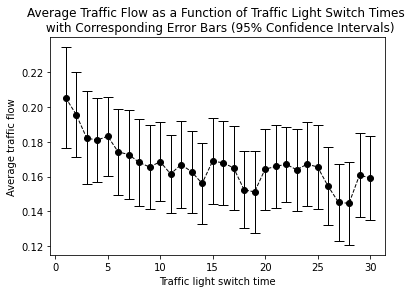

In [36]:
#plot the average traffic flow against traffic switch time with corresponding error bars
%matplotlib inline
plt.figure()
plt.errorbar(np.arange(1,31), av_traf_flow_crossroads, conf_int_crossroads,color='black', marker='o', capsize=5, linestyle='--', linewidth=1) 
plt.xlabel('Traffic light switch time')
plt.ylabel('Average traffic flow')
plt.title('Average Traffic Flow as a Function of Traffic Light Switch Times \n with Corresponding Error Bars (95% Confidence Intervals)')
plt.show()



**Average Traffic Flow vs. Probability of Turning Right at the Intersection**

In [18]:
def av_flow_vs_p_turn_right(range_start, range_end, interval,reps):
    '''
    This function runs a traffic simulation for a given number of updates, repeats the simulation for a given number of times for each of the given turning right probability values.
    The goal of the experiment is to find the dependency between turning right probability and average flow rate.
    ------
    Inputs:
    range_start: float 
        the starting turning right probability
    range_end: float
        the ending turning right probability
    interval: float
        increments of turning right probability
    reps: int
        the number of times to repeat a simulation for a given turning right probability
    ------
    Outputs: 
    av_traf_flow: lst
        a 2D list containing average traffic flow values for each turning right probability for each road
    conf_int: lst
        a 2D list containing 95% CI of the mean values for each turning right probability for each road
    '''
    av_traf_flow=[]
    conf_int=[]

    for i in tqdm(np.arange(range_start,range_end,interval)): #for each turning right probability

        traf_flow_1=[]
        traf_flow_2=[]
        traf_flow_3=[]
        traf_flow_4=[]

        for k in range(reps):

            road1 = Road_Emp_An(
                road_length=30, car_density=0.17, max_speed=5, prob_slow=0.5,traffic_light_state='green', prob_turn_right = i,traffic_light_switch=30,traffic_light_position=[5,24])
            road2 = Road_Emp_An(
                road_length=70, car_density=0.15, max_speed=5, prob_slow=0.5,traffic_light_state='red', prob_turn_right = i,traffic_light_switch=30,traffic_light_position=[15,54])
            road3 = Road_Emp_An(
                road_length=30, car_density=0.16, max_speed=5, prob_slow=0.5,traffic_light_state='green', prob_turn_right = i,traffic_light_switch=30,traffic_light_position=[5,24])
            road4 = Road_Emp_An(
                road_length=70, car_density=0.15, max_speed=5, prob_slow=0.5,traffic_light_state='red', prob_turn_right = i,traffic_light_switch=30,traffic_light_position=[15,54])

            intersection(road1,road2,road3,road4)

            update_sim(200,road1,road2,road3,road4) #200 updates

            #take the final average traffic flow value
            traf_flow_1.append(road1.av_traffic_flow[-1])
            traf_flow_2.append(road2.av_traffic_flow[-1])
            traf_flow_3.append(road3.av_traffic_flow[-1])
            traf_flow_4.append(road4.av_traffic_flow[-1])


        av_traf_flow.append([np.mean(traf_flow_1),np.mean(traf_flow_2),np.mean(traf_flow_3),np.mean(traf_flow_4)]) #store average traffic flow for each road


        conf_int.append([compute_conf_int(traf_flow_1), compute_conf_int(traf_flow_2),compute_conf_int(traf_flow_3),compute_conf_int(traf_flow_4)]) #store 95% CI for each road


    return   av_traf_flow, conf_int


av_traf_flow, conf_int = av_flow_vs_p_turn_right(0, 1.1, 0.1,150) #turning right probability form 0 to 1 by 0.1 increments, 150 repetitions

100%|██████████| 11/11 [02:32<00:00, 13.82s/it]


In [19]:
#average over the roads
av_traf_flow_crossroads=np.mean(av_traf_flow,axis=1)
conf_int_crossroads=np.mean(conf_int,axis=1)

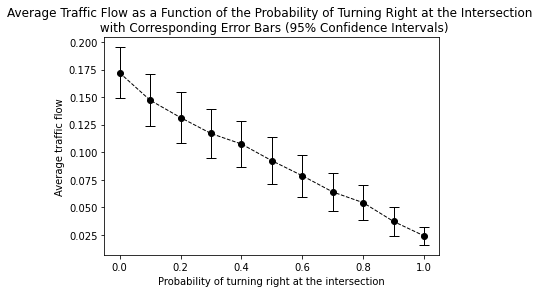

In [20]:
#plot the average traffic flow against the probability of turning right with corresponding error bars
plt.figure()
plt.errorbar(np.arange(0,1.1,0.1), av_traf_flow_crossroads, conf_int_crossroads,color='black', marker='o', capsize=5, linestyle='--', linewidth=1) 
plt.xlabel('Probability of turning right at the intersection')
plt.ylabel('Average traffic flow')
plt.title('Average Traffic Flow as a Function of the Probability of Turning Right at the Intersection \n with Corresponding Error Bars (95% Confidence Intervals)')
plt.show()

**Average Traffic Flow vs. Probability of Slowing Down**

In [22]:
def av_flow_vs_p_slowdown(range_start, range_end, interval,reps):
    '''
    This function runs a traffic simulation for a given number of updates, repeats the simulation for a given number of times for each of the given slowing down probability values.
    The goal of the experiment is to find the dependency between slowing down  probability and average flow rate.
    ------
    Inputs:
    range_start: float 
        the starting slowing down  probability
    range_end: float
        the ending slowing down  probability
    interval: float
        increments of slowing down  probability
    reps: int
        the number of times to repeat a simulation for a given slowing down  probability
    ------
    Outputs: 
    av_traf_flow: lst
        a 2D list containing average traffic flow values for each slowing down  probability for each road
    conf_int: lst
        a 2D list containing 95% CI of the mean values for each slowing down  probability for each road
    '''
    av_traf_flow=[]
    conf_int=[]

    for i in tqdm(np.arange(range_start,range_end,interval)): #for each slowing down probability

        traf_flow_1=[]
        traf_flow_2=[]
        traf_flow_3=[]
        traf_flow_4=[]

        for k in range(reps):

            road1 = Road_Emp_An(
                road_length=30, car_density=0.17, max_speed=5, prob_slow=i,traffic_light_state='green', prob_turn_right = 0.18,traffic_light_switch=30,traffic_light_position=[5,24])
            road2 = Road_Emp_An(
                road_length=70, car_density=0.15, max_speed=5, prob_slow=i,traffic_light_state='red', prob_turn_right = 0.19,traffic_light_switch=30,traffic_light_position=[15,54])
            road3 = Road_Emp_An(
                road_length=30, car_density=0.16, max_speed=5, prob_slow=i,traffic_light_state='green', prob_turn_right = 0.19,traffic_light_switch=30,traffic_light_position=[5,24])
            road4 = Road_Emp_An(
                road_length=70, car_density=0.15, max_speed=5, prob_slow=i,traffic_light_state='red', prob_turn_right = 0.23,traffic_light_switch=30,traffic_light_position=[15,54])

            intersection(road1,road2,road3,road4)

            update_sim(200,road1,road2,road3,road4) #200 updates

            #take the final average traffic flow value
            traf_flow_1.append(road1.av_traffic_flow[-1])
            traf_flow_2.append(road2.av_traffic_flow[-1])
            traf_flow_3.append(road3.av_traffic_flow[-1])
            traf_flow_4.append(road4.av_traffic_flow[-1])


        av_traf_flow.append([np.mean(traf_flow_1),np.mean(traf_flow_2),np.mean(traf_flow_3),np.mean(traf_flow_4)]) #store average traffic flow for each road


        conf_int.append([compute_conf_int(traf_flow_1), compute_conf_int(traf_flow_2),compute_conf_int(traf_flow_3),compute_conf_int(traf_flow_4)]) #store 95% CI for each road

    return   av_traf_flow, conf_int


av_traf_flow, conf_int = av_flow_vs_p_slowdown(0, 1.1, 0.1,150) #probability of slowing down from 0 to 1 by 0.1 increments, 150 repetitions

100%|██████████| 11/11 [02:48<00:00, 15.31s/it]


In [23]:
#average over the roads 
av_traf_flow_crossroads=np.mean(av_traf_flow,axis=1)
conf_int_crossroads=np.mean(conf_int,axis=1)

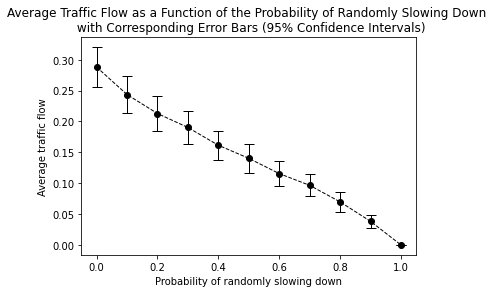

In [24]:
#plot the average traffic flow against the probability of randomly slowing down with corresponding error bars
plt.figure()
plt.errorbar(np.arange(0,1.1,0.1), av_traf_flow_crossroads, conf_int_crossroads,color='black', marker='o', capsize=5, linestyle='--', linewidth=1) 
plt.xlabel('Probability of randomly slowing down')
plt.ylabel('Average traffic flow')
plt.title('Average Traffic Flow as a Function of the Probability of Randomly Slowing Down \n with Corresponding Error Bars (95% Confidence Intervals)')
plt.show()

**Average Traffic Flow vs. Maximum Speed**

In [25]:
def av_flow_vs_max_speed(range_start, range_end, reps):
    '''
    This function runs a traffic simulation for a given number of updates, repeats the simulation for a given number of times for each of the given maximum speed values.
    The goal of the experiment is to find the dependency between maximum speed and average flow rate and optimize for the maximum speed .
    ------
    Inputs:
    range_start: float 
        the starting maximum speed 
    range_end: float
        the ending maximum speed 
    reps: int
        the number of times to repeat a simulation for a given maximum speed 
    ------
    Outputs: 
    av_traf_flow: lst
        a 2D list containing average traffic flow values for each maximum speed for each road
    conf_int: lst
        a 2D list containing 95% CI of the mean values for each maximum speed for each road
    '''
    av_traf_flow=[]
    conf_int=[]
    for i in tqdm(range(range_start,range_end)): #for each maximum speed

        traf_flow_1=[]
        traf_flow_2=[]
        traf_flow_3=[]
        traf_flow_4=[]

        for k in range(reps):

            road1 = Road_Emp_An(
                road_length=30, car_density=0.17, max_speed=i, prob_slow=0.5,traffic_light_state='green', prob_turn_right = 0.18,traffic_light_switch=30,traffic_light_position=[5,24])
            road2 = Road_Emp_An(
                road_length=70, car_density=0.15, max_speed=i, prob_slow=0.5,traffic_light_state='red', prob_turn_right = 0.19,traffic_light_switch=30,traffic_light_position=[15,54])
            road3 = Road_Emp_An(
                road_length=30, car_density=0.16, max_speed=i, prob_slow=0.5,traffic_light_state='green', prob_turn_right = 0.19,traffic_light_switch=30,traffic_light_position=[5,24])
            road4 = Road_Emp_An(
                road_length=70, car_density=0.15, max_speed=i, prob_slow=0.5,traffic_light_state='red', prob_turn_right = 0.23,traffic_light_switch=30,traffic_light_position=[15,54])

            intersection(road1,road2,road3,road4)

            update_sim(200,road1,road2,road3,road4) #200 updates

            #take the final average traffic flow value
            traf_flow_1.append(road1.av_traffic_flow[-1])
            traf_flow_2.append(road2.av_traffic_flow[-1])
            traf_flow_3.append(road3.av_traffic_flow[-1])
            traf_flow_4.append(road4.av_traffic_flow[-1])

        av_traf_flow.append([np.mean(traf_flow_1),np.mean(traf_flow_2),np.mean(traf_flow_3),np.mean(traf_flow_4)]) #store average traffic flow for each road


        conf_int.append([compute_conf_int(traf_flow_1), compute_conf_int(traf_flow_2),compute_conf_int(traf_flow_3),compute_conf_int(traf_flow_4)]) #store 95% CI for each road


    return   av_traf_flow, conf_int


av_traf_flow, conf_int = av_flow_vs_max_speed(1, 11, 150) #maximum speed from 1 to 10, 150 repetitions

100%|██████████| 10/10 [02:22<00:00, 14.27s/it]


In [26]:
#average over the roads 
av_traf_flow_crossroads=np.mean(av_traf_flow,axis=1)
conf_int_crossroads=np.mean(conf_int,axis=1)

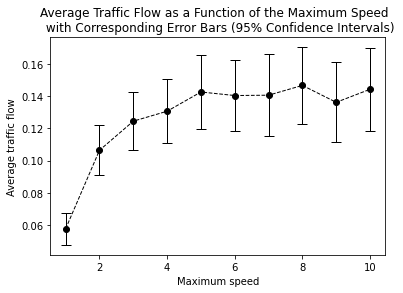

In [27]:
#plot the average traffic flow against the probability of randomly slowing down with corresponding error bars
plt.figure()
plt.errorbar(np.arange(1,11), av_traf_flow_crossroads, conf_int_crossroads,color='black', marker='o', capsize=5, linestyle='--', linewidth=1) 
plt.xlabel('Maximum speed')
plt.ylabel('Average traffic flow')
plt.title('Average Traffic Flow as a Function of the Maximum Speed  \n with Corresponding Error Bars (95% Confidence Intervals)')
plt.show()

Average Queue Length vs. Time

In [28]:
def av_queue_length_vs_time(reps):
    '''
    This function runs a traffic simulation for a given number of updates, repeats the simulation for a given number of times, and stores the average queue length values.
    The goal of the experiment is to see how the average queue length changes over time.
    ------
    Inputs:
    reps: int
        the number of times to repeat a simulation for a given slowing down  probability
    ------
    Outputs: 
    av_queue_tl_1: lst
        a 2D list containing average queue length values over time for each road for the first traffic light
    av_queue_tl_2: lst
        a 2D list containing average queue length values over time for each road for the second traffic light
    error_queue_tl_1: lst
        a 2D list containing corresponding 95% CI values for each road for the first traffic light
    error_queue_tl_2: lst
        a 2D list containing corresponding 95% CI values for each road for the second traffic light
    '''

    queues_tl_1= {'queue_1':[], 'queue_2':[], 'queue_3':[], 'queue_4':[]} #first traffic light 
    queues_tl_2= {'queue_1':[], 'queue_2':[], 'queue_3':[], 'queue_4':[]} #second traffic light

    for i in tqdm(range(reps)):

        road1 = Road_Emp_An(
                road_length=30, car_density=0.17, max_speed=5, prob_slow=0.5,traffic_light_state='green', prob_turn_right = 0.18,traffic_light_switch=30,traffic_light_position=[5,24])
        road2 = Road_Emp_An(
                road_length=70, car_density=0.15, max_speed=5, prob_slow=0.5,traffic_light_state='red', prob_turn_right = 0.19,traffic_light_switch=30,traffic_light_position=[15,54])
        road3 = Road_Emp_An(
                road_length=30, car_density=0.16, max_speed=5, prob_slow=0.5,traffic_light_state='green', prob_turn_right = 0.19,traffic_light_switch=30,traffic_light_position=[5,24])
        road4 = Road_Emp_An(
                road_length=70, car_density=0.15, max_speed=5, prob_slow=0.5,traffic_light_state='red', prob_turn_right = 0.23,traffic_light_switch=30,traffic_light_position=[15,54])

        roads=[road1,road2,road3,road4]
        intersection(road1,road2,road3,road4)
        update_sim(150,road1,road2,road3,road4)

        #store queue length values in corresponding roads' and corresponding traffic lights' sections of the dictionaries
        for idx, key in enumerate(queues_tl_1.keys()):
            queue = roads[idx].queue_length
            queues_tl_1[key].append([i[0] for i in queue])
            queues_tl_2[key].append([i[1] for i in queue])

    av_queue_tl_1, av_queue_tl_2, error_queue_tl_1, error_queue_tl_2 = [], [], [], []


    #average queue length values over repetitions and compute corresponding 95% CI values
    for idx, key in enumerate(queues_tl_1.keys()):
        av_queue_tl_1.append(np.mean(queues_tl_1[key],axis=0))
        av_queue_tl_2.append(np.mean(queues_tl_2[key],axis=0))

        error_queue_tl_1.append(np.mean(queues_tl_1[key], axis=0) + 1.96*sts.sem(queues_tl_1[key], axis=0) - 
                                np.mean(queues_tl_1[key], axis=0) - 1.96*sts.sem(queues_tl_1[key], axis=0))
        error_queue_tl_2.append(np.mean(queues_tl_2[key], axis=0) + 1.96*sts.sem(queues_tl_2[key], axis=0) -
                                np.mean(queues_tl_2[key], axis=0) - 1.96*sts.sem(queues_tl_2[key], axis=0))

    return av_queue_tl_1, av_queue_tl_2, error_queue_tl_1, error_queue_tl_2


av_queue_tl_1, av_queue_tl_2, error_queue_tl_1, error_queue_tl_2 = av_queue_length_vs_time(150) #150 repetitions

100%|██████████| 150/150 [00:11<00:00, 13.11it/s]


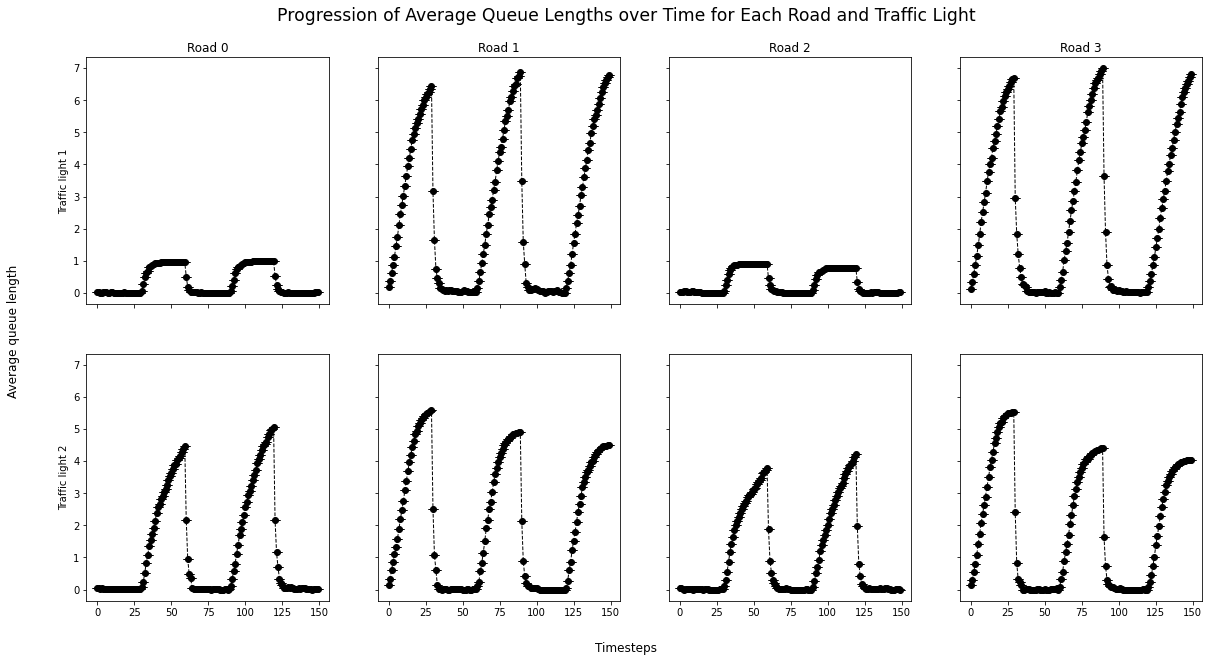

In [29]:
#plot average queue length progression over time for each road and each traffic light
fig, ax = plt.subplots(2, 4, figsize = (20, 10), sharex = True, sharey = True)

for i in range(4):
    ax[0][i].errorbar(range(150), av_queue_tl_1[i], error_queue_tl_1[i],color='black', marker='o', capsize=5, linestyle='--', linewidth=1)
    ax[0][i].set_title(f'Road {i}')
    ax[1][i].errorbar(range(150), av_queue_tl_2[i], error_queue_tl_2[i],color='black', marker='o', capsize=5, linestyle='--', linewidth=1) 

    if i == 0:
        ax[0][i].set_ylabel('Traffic light 1')
        ax[1][i].set_ylabel('Traffic light 2')

fig.supxlabel('Timesteps', y = 0.05)
fig.supylabel('Average queue length', x = 0.07)
fig.suptitle('Progression of Average Queue Lengths over Time for Each Road and Traffic Light', y = 0.95,fontsize='xx-large')
plt.show()


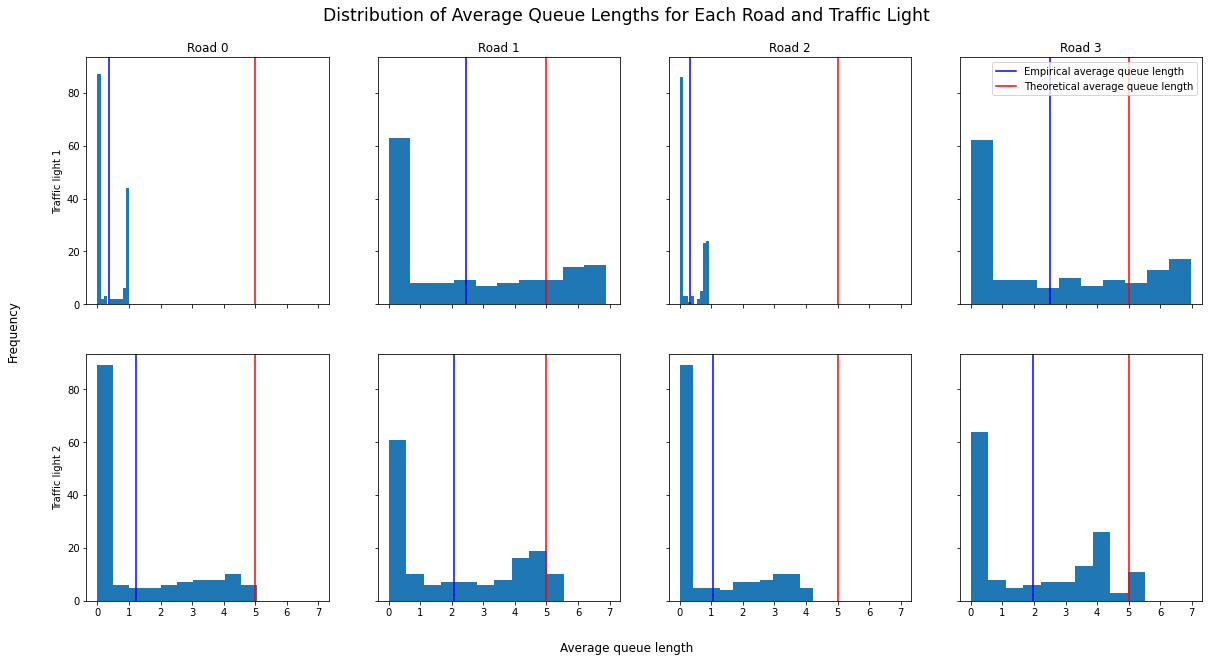

In [30]:
#plot average queue length histograms for each road and each traffic light
fig, ax = plt.subplots(2, 4, figsize = (20, 10), sharex = True, sharey = True)

for i in range(4):
    ax[0][i].hist(av_queue_tl_1[i])
    ax[0][i].set_title(f'Road {i}')
    ax[1][i].hist(av_queue_tl_2[i]) 

    ax[0][i].axvline(np.mean(av_queue_tl_1[i]),label='Empirical average queue length', color='blue')
    ax[1][i].axvline(np.mean(av_queue_tl_2[i]),label='Empirical average queue Length',color='blue')

    ax[0][i].axvline(5,label='Theoretical average queue length',color='red')
    ax[1][i].axvline(5,label='Theoretical average queue length',color='red')

    if i == 0:
        ax[0][i].set_ylabel('Traffic light 1')
        ax[1][i].set_ylabel('Traffic light 2')

fig.supxlabel('Average queue length', y = 0.05)
fig.supylabel('Frequency', x = 0.07)
fig.suptitle('Distribution of Average Queue Lengths for Each Road and Traffic Light', y = 0.95,fontsize='xx-large')
ax[0][3].legend()
plt.show()

## **References**

Session 6. (n.d.). Forum. Retrieved March 16, 2023, from https://forum.minerva.edu/?next=/app/courses/2571/sections/10241/classes/71256
Session 9. (n.d.). Forum. Retrieved March 16, 2023, from https://forum.minerva.edu/?next=/app/courses/2571/sections/10241/classes/70752